In [ ]:
# 필요한 라이브러리 설치
!pip install kaggle
!pip install tensorflow scikit-learn matplotlib

# Kaggle API 설정
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# 데이터셋 다운로드
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip -d brain-tumor-mri-dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: brain-tumor-mri-dataset/Training/glioma/T

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리 함수
def load_and_preprocess_data(data_dir, img_size=(224, 224)):
    images = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(
                img_path,
                target_size=img_size,
                color_mode='rgb'
            )
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = tf.keras.applications.resnet50.preprocess_input(img)
            images.append(img)
            labels.append(class_name)
    return np.array(images), np.array(labels)

- 데이터를 Resnet50에 맞춰 입력 크기 설정 및 전처리

- ImageDataGenerator : 훈련 데이터에 회전, 이동, 줌, 반전 등을 줘서 다양성을 증가시켜줌




In [ ]:
# 데이터 로드 및 전처리
data_dir = '/content/brain-tumor-mri-dataset/Training'
images, labels = load_and_preprocess_data(data_dir)

# 레이블 인코딩
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

# 데이터 증강
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

- 기존 Resnet50 모델에서 상위 30개의 레이어만을 학습 진행

- GlobalAveragePooling2D : 특정 맵의 공간 차원을 줄이는 층

- BatchNormalization : 내부 공변량 이동을 줄이고 학습을 안전화하는 층

- Dropout : 과적합을 방지하기 위해서 특정 weight들을 학습시키지 않게하는 층

In [ ]:
def create_resnet_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    for layer in base_model.layers[:-30]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

- EarlyStopping : 과적합을 방지하고 최적의 시점에서 학습을 중단하는 기법

- ReduceLROnPlateau : validation loss가 개선되지 않을 때 학습률을 감소시키는 기법

- ModelCheckpoint : 최고 성능의 모델을 저장


In [ ]:
# 모델 생성 및 컴파일
model = create_resnet_model()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='brain_tumor_best_model.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
]

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# 모델 학습
batch_size = 32
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


142/142 ━━━━━━━━━━━━━━━━━━━━ 86s 439ms/step - accuracy: 0.5719 - loss: 1.0753 - val_accuracy: 0.9151 - val_loss: 0.2707 - learning_rate: 1.0000e-04
Epoch 2/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9375 - loss: 0.1921

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9375 - loss: 0.1921 - val_accuracy: 0.9151 - val_loss: 0.2746 - learning_rate: 1.0000e-04
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.8835 - loss: 0.3421 - val_accuracy: 0.9300 - val_loss: 0.1897 - learning_rate: 1.0000e-04
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9062 - loss: 0.2769 - val_accuracy: 0.9318 - val_loss: 0.1827 - learning_rate: 1.0000e-04
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.9117 - loss: 0.2463 - val_accuracy: 0.9361 - val_loss: 0.1581 - learning_rate: 1.0000e-04
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9062 - loss: 0.3286 - val_accuracy: 0.9379 - val_loss: 0.1617 - learning_rate: 1.0000e-04
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 47s 314ms/step - accuracy: 0.9396 - loss: 0.1654 - val_accuracy: 0.9563 - val_loss: 0.1176 - learning_rate: 1.0000e-04
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 

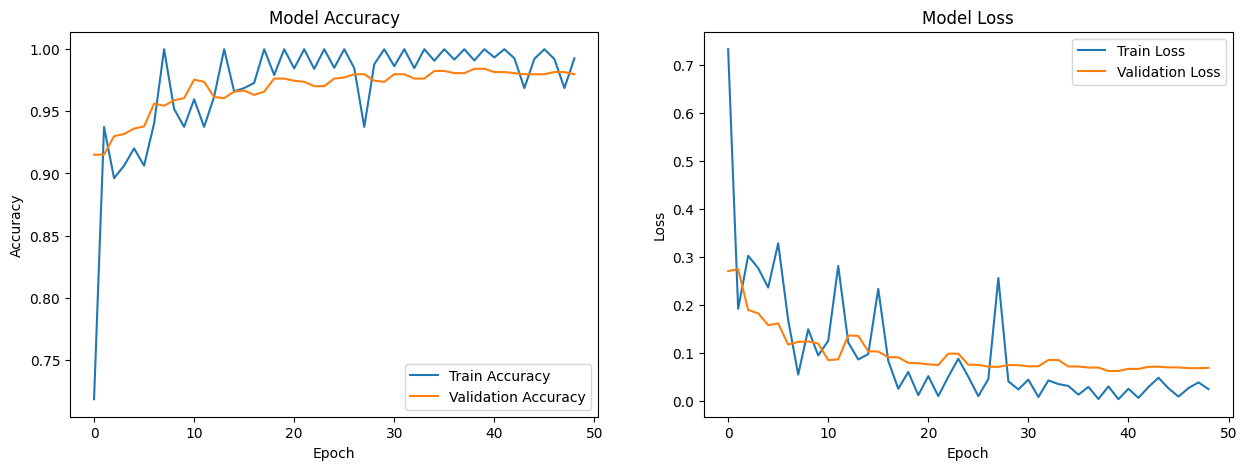

In [ ]:
# 학습 과정 시각화
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9886 - loss: 0.0276

Test Loss: 0.0406
Test Accuracy: 0.9863
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


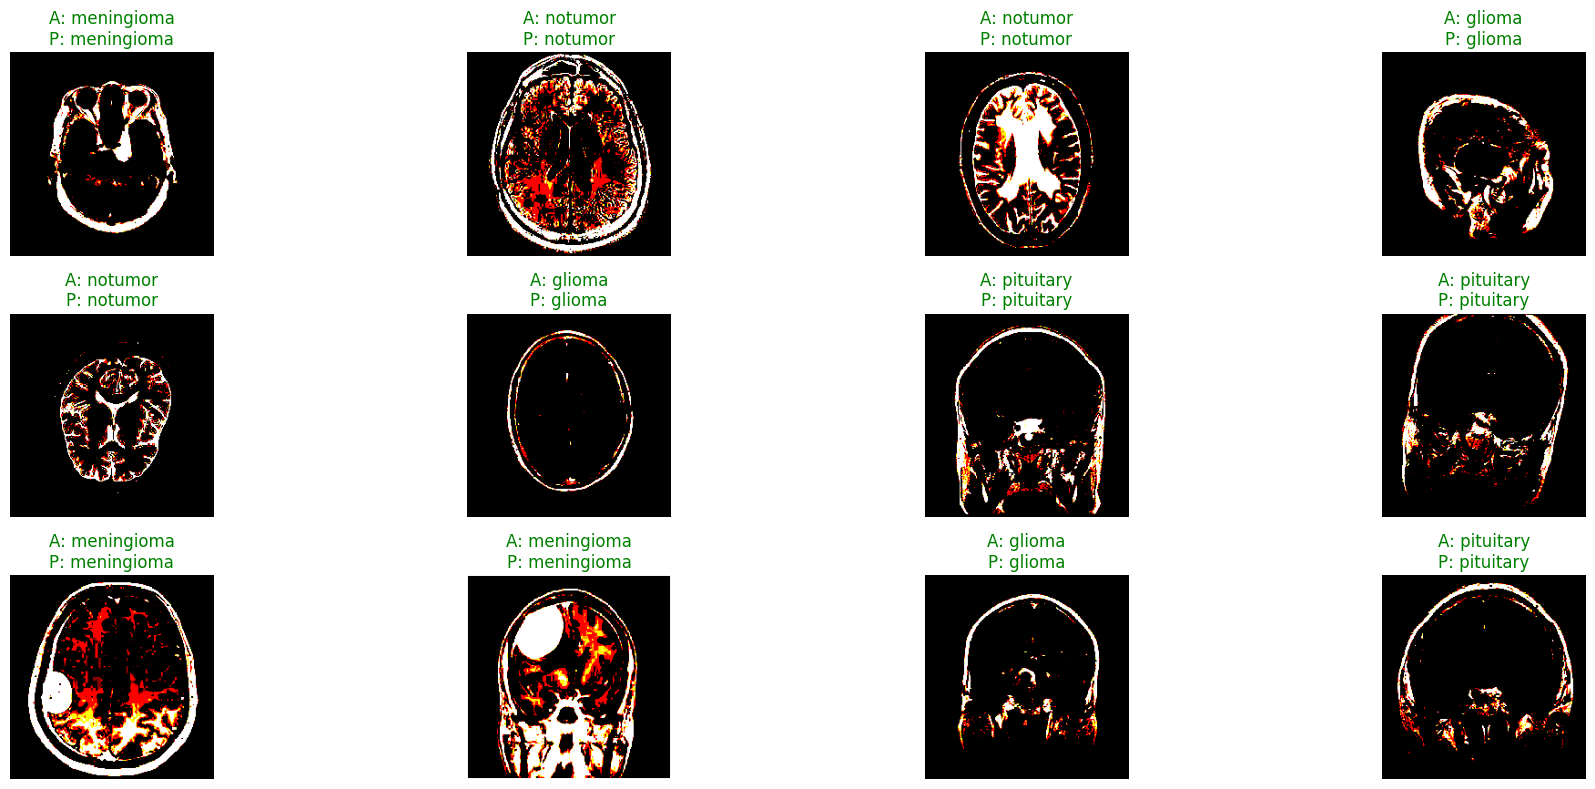

In [ ]:
def visualize_predictions(model, X_test, y_test, le, num_samples=12):
    plt.figure(figsize=(20, 8))
    predictions = model.predict(X_test)

    # 각 클래스별로 인덱스 추출
    class_indices = {cls: np.where(y_test == i)[0] for i, cls in enumerate(le.classes_)}

    samples_per_class = num_samples // len(le.classes_)
    sample_indices = []

    # 각 클래스에서 균등하게 샘플 선택
    for indices in class_indices.values():
        sample_indices.extend(np.random.choice(indices, min(samples_per_class, len(indices)), replace=False))

    # 부족한 샘플 수만큼 무작위로 추가 선택
    if len(sample_indices) < num_samples:
        additional_samples = np.random.choice(
            np.concatenate(list(class_indices.values())),
            num_samples - len(sample_indices),
            replace=False
        )
        sample_indices.extend(additional_samples)

    # 선택된 샘플들을 무작위로 섞음
    np.random.shuffle(sample_indices)

    for i, idx in enumerate(sample_indices[:num_samples]):
        plt.subplot(3, 4, i + 1)
        plt.imshow(X_test[idx] / 2 + 0.5)  # 정규화 복원
        plt.axis('off')
        actual = le.inverse_transform([y_test[idx]])[0]
        predicted = le.inverse_transform([np.argmax(predictions[idx])])[0]
        color = 'green' if actual == predicted else 'red'
        plt.title(f'A: {actual}\nP: {predicted}', color=color)

    plt.tight_layout()
    plt.show()

# Testing 폴더의 데이터 로드 및 전처리
test_data_dir = '/content/brain-tumor-mri-dataset/Testing'
X_test, y_test = load_and_preprocess_data(test_data_dir)

# 레이블 인코딩
y_test_encoded = le.transform(y_test)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 예측 결과 시각화
visualize_predictions(model, X_test, y_test_encoded, le)